In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from rflearn.env import BlackJack, GridWorld, CliffGridWorld
from rflearn.algo import MCEpsilonSoft
from rflearn.utils import zero_values, random_policy

# Cliff Gridworld

In [79]:
cgrid = CliffGridWorld(4, 10)
value = zero_values(cgrid)
policy = random_policy(cgrid)

mc_model = MCEpsilonSoft(cgrid, value, policy, qvalue=None)
mc_model.fit(gamma=1, epsilon=0.1, lam=0.1, kbatch=40)

In [80]:
print(np.array(cgrid.grid))
print(np.array(cgrid.S).reshape(cgrid.shape))

[[0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 1 1 1 1 1 1 1 1 0]]
[[ 0  1  2  3  4  5  6  7  8  9]
 [10 11 12 13 14 15 16 17 18 19]
 [20 21 22 23 24 25 26 27 28 29]
 [30 31 32 33 34 35 36 37 38 39]]


In [67]:
mc_model.transform(50)

100%|██████████| 50/50 [00:01<00:00, 42.98it/s]


In [76]:
q_vals = pd.Series(mc_model.qvalue).unstack()[cgrid.A]
pi_vals = pd.DataFrame(mc_model.policy, index=mc_model.env.S, columns=mc_model.env.A)
v_vals = (q_vals * pi_vals).sum(1)
np.round(v_vals.values.reshape(cgrid.shape))

array([[-2.900e+01, -2.800e+01, -3.100e+01, -1.200e+01, -1.000e+01,
        -9.000e+00, -7.000e+00, -6.000e+00, -5.000e+00, -2.200e+01],
       [-1.700e+01, -2.400e+01, -1.800e+01, -1.300e+01, -7.300e+01,
        -7.800e+01, -4.700e+01, -4.000e+01, -4.000e+00, -2.000e+00],
       [-1.800e+01, -3.200e+01, -3.400e+01, -2.000e+01, -1.980e+02,
        -1.004e+03, -5.820e+02, -3.580e+02, -5.900e+01, -1.000e+00],
       [-2.200e+01, -1.640e+02, -4.960e+02, -2.690e+02, -1.457e+03,
        -2.162e+03, -1.929e+03, -3.570e+02, -9.440e+02,  0.000e+00]])

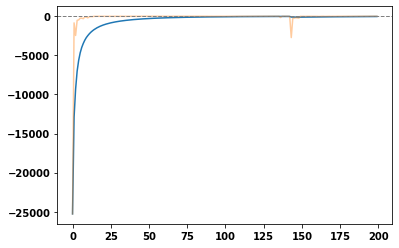

In [70]:
# pd.Series(mc_model.hist['avg_r']).plot()
pd.Series(mc_model.hist['avg_r']).ewm(halflife=25).mean().plot()
pd.Series(mc_model.hist['avg_r']).plot(alpha=0.4)
plt.axhline(0, linestyle='--', color='grey',linewidth=1)

# Gridworld MC

In [3]:
# _grid = [
#     [0, 1, 1, 1, 1, 1, 1],
#     [0, 0, 0, 0, 0, 0, 0],
#     [1, 1, 1, 1, 1, 1, 0],
#     [0, 0, 0, 0, 0, 0, 0],
# ]
# grid = GridWorld(grid=_grid, terminals=[0])
grid = GridWorld(4,4)
value = zero_values(grid)
policy = random_policy(grid)

mc_model = MCEpsilonSoft(grid, value, policy, qvalue=None)
mc_model.fit(gamma=1, epsilon=0.05, kbatch=30)

In [10]:
mc_model.transform(iter=100)

100%|██████████| 100/100 [00:00<00:00, 217.74it/s]


In [83]:
q_vals = pd.Series(mc_model.qvalue).unstack()[grid.A]
pi_vals = pd.DataFrame(mc_model.policy, index=mc_model.env.S, columns=mc_model.env.A)
v_vals = (q_vals * pi_vals).sum(1)
np.round(v_vals.values.reshape(grid.shape))

ValueError: cannot reshape array of size 40 into shape (2,5)

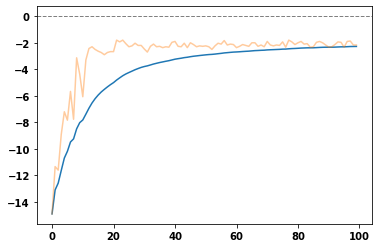

In [5]:
# pd.Series(mc_model.hist['avg_r']).plot()
pd.Series(mc_model.hist['avg_r']).ewm(halflife=25).mean().plot()
pd.Series(mc_model.hist['avg_r']).plot(alpha=0.4)
plt.axhline(0, linestyle='--', color='grey',linewidth=1)

In [133]:
pd.Series(mc_model.sa_counts).unstack()[mc_model.env.A]

,up,down,left,right
0,0,0,0,0
1,100,100,100,100
2,100,100,100,100
3,100,100,100,100
4,100,100,100,100
5,100,100,100,100
6,100,100,100,100
7,100,100,100,100
8,100,100,100,100
9,100,100,100,100


# Blackjack MC

In [31]:
def fix_policy(env, threshold=20):
    policy = []
    for idx in env.S:
        state = env._to_state(idx)
        if state[1] >= threshold:
            policy.append([0, 1])
        else:
            policy.append([1, 0])
    policy = np.array(policy).astype('float')
    return policy

In [104]:
game = BlackJack(debug=False)
value = np.zeros(shape=len(game.S))
# policy = fix_policy(game, 20)
policy = random_policy(game)

mc_model = MCEpsilonSoft(game, value, policy)
mc_model.fit(gamma=1, epsilon=0.01, kbatch=30)

In [105]:
mc_model.transform(6000)

100%|██████████| 6000/6000 [00:22<00:00, 261.32it/s]


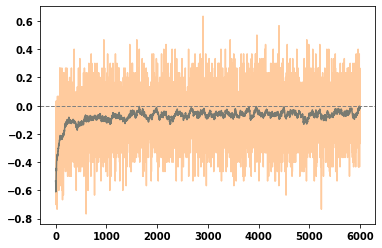

In [106]:
pd.Series(mc_model.hist['avg_r']).ewm(halflife=25).mean().plot()
pd.Series(mc_model.hist['avg_r']).plot(alpha=0.4)
plt.axhline(0, linestyle='--', color='grey',linewidth=1)

In [107]:
idx = pd.MultiIndex.from_tuples([game._to_state(s) for s in game.S])
q_vals = pd.Series(mc_model.qvalue).unstack()[game.A]
q_vals.index = idx
pi_vals = pd.DataFrame(mc_model.policy, index=mc_model.env.S, columns=mc_model.env.A)
pi_vals.index = idx
v_vals = (q_vals * pi_vals).sum(1)

cnts = pd.Series(mc_model.sa_counts).unstack()[mc_model.env.A]
cnts.index = idx

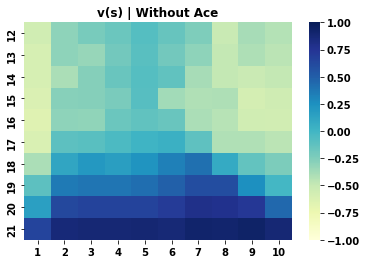

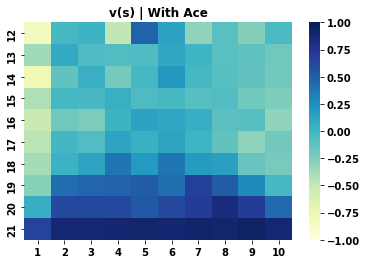

In [108]:
import seaborn as sns

d = np.round(v_vals.unstack(), 2).T
sns.heatmap(d[False].T, vmin=-1, vmax=1, cmap="YlGnBu")
plt.title('v(s) | Without Ace')
plt.show()
sns.heatmap(d[True].T, vmin=-1, vmax=1, cmap="YlGnBu")
plt.title('v(s) | With Ace')
plt.show()